In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import datetime as dt
from sklearn.ensemble import RandomForestClassifier

In [13]:
df = pd.read_csv('CC Fraud.csv', index_col=0)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [14]:
# Create the column AGE 
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (pd.to_datetime('today')-df['dob']).astype('<m8[Y]')

#  we no longer need DOB after making AGE
df.drop('dob', axis=1, inplace=True)

# convert TDTT to a datetime, and convert that into an integer representing its ordinal value
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_date_trans_time'] = df['trans_date_trans_time'].map(dt.datetime.toordinal)

In [15]:
# # Check for missing values
print(df.isnull().sum())

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
age                      0
dtype: int64


In [16]:
# Check for duplicates
print(df.duplicated().sum())

0


In [17]:
fraud_by_merchant_category = df.groupby('category')['is_fraud'].sum()
print(fraud_by_merchant_category)

category
entertainment      233
food_dining        151
gas_transport      618
grocery_net        134
grocery_pos       1743
health_fitness     133
home               198
kids_pets          239
misc_net           915
misc_pos           250
personal_care      220
shopping_net      1713
shopping_pos       843
travel             116
Name: is_fraud, dtype: int64


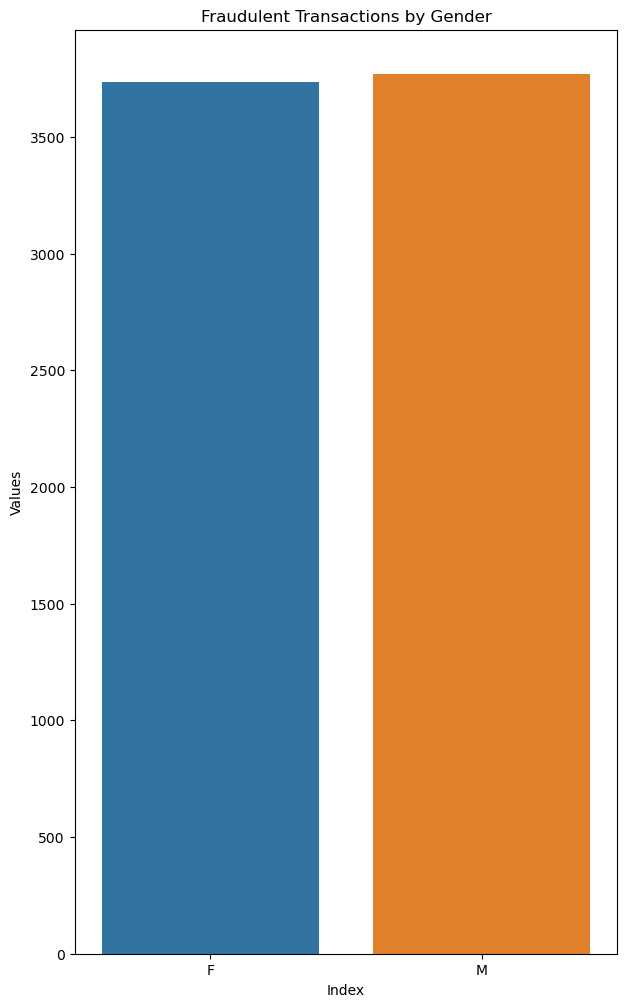

In [18]:
 # Create a bar plot for GENDER pattern inference
fraud_by_gender = df.groupby('gender')['is_fraud'].sum()
fraud_by_age = df.groupby('age')['is_fraud'].sum()
plt.figure(figsize=(7, 12))
sns.barplot(x=fraud_by_gender.index, y=fraud_by_gender.values)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Fraudulent Transactions by Gender')
plt.show()

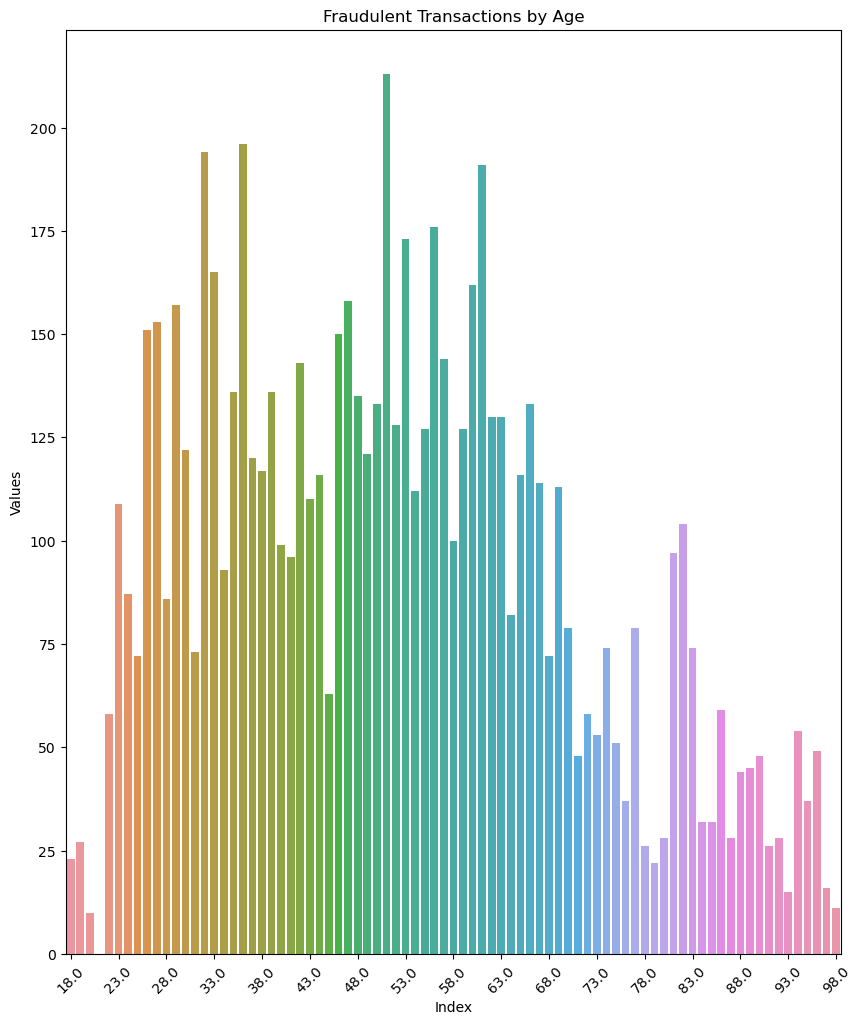

In [19]:
# Create a bar plot for AGE pattern inference
plt.figure(figsize=(10, 12))
sns.barplot(x=fraud_by_age.index, y= fraud_by_age.values)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Fraudulent Transactions by Age')
plt.xticks(range(0, len(fraud_by_age.index), 5), fraud_by_age.index[::5], rotation=45)
plt.show()

In [20]:
# CHI square test for FRAUD and GENDER relation
chitable = pd.crosstab(df["is_fraud"], df["gender"])
stats, p_value, dof, expected = chi2_contingency(chitable)
print(stats)
print(p_value)
print(dof)
print("\n",chitable)

75.51456622055794
3.627211385830374e-18
1

 gender         F       M
is_fraud                
0         706128  583041
1           3735    3771


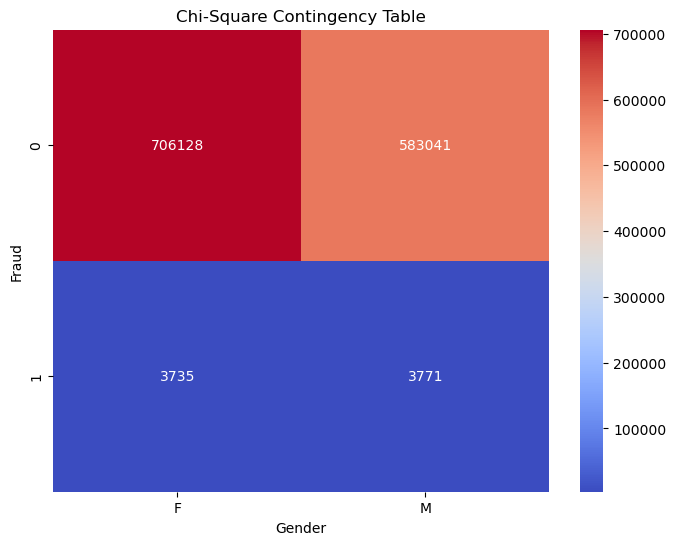

In [21]:
    #  Plot the Chi table using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(chitable, annot=True, cmap='coolwarm', fmt='d')
plt.title('Chi-Square Contingency Table')
plt.xlabel('Gender')
plt.ylabel('Fraud')
plt.show()


In [22]:
    # Filter states with a fraudulent rate of at least 5%, greatest to least
fraud_by_state = df.groupby('state')['is_fraud'].mean()
high_fraud_states = fraud_by_state[fraud_by_state > 0.05]
print(high_fraud_states)


state
DE    1.0
Name: is_fraud, dtype: float64


In [23]:
    # Print the sum of unique cities, filter cities with a fraudulent rate of at least 20% and print the sum of high fraud cities
fraud_by_city = df.groupby('city')['is_fraud'].mean()
unique_cities = df['city'].nunique()
print("Unique cities:", unique_cities)
high_fraud_cities = fraud_by_city[fraud_by_city > .20] 
print("Count of fraud rate > 20%:", high_fraud_cities.sum())
print(high_fraud_cities)

Unique cities: 894
Count of fraud rate > 20%: 58.0
city
Angwin            1.0
Ashland           1.0
Beacon            1.0
Brookfield        1.0
Bruce             1.0
Buellton          1.0
Byesville         1.0
Chattanooga       1.0
Clarion           1.0
Claypool          1.0
Clinton           1.0
Coulee Dam        1.0
Crouse            1.0
Downey            1.0
East China        1.0
Freeport          1.0
Gaines            1.0
Granbury          1.0
Greenport         1.0
Grenola           1.0
Hubbell           1.0
Irvington         1.0
Isanti            1.0
Kaktovik          1.0
Karns City        1.0
La Grande         1.0
Las Vegas         1.0
Lockhart          1.0
Madisonville      1.0
Marshall          1.0
Medford           1.0
Melville          1.0
Mineral           1.0
Morven            1.0
Moss Point        1.0
Mount Vernon      1.0
Mountain City     1.0
Nanuet            1.0
Nicholson         1.0
Noblesville       1.0
Norfolk           1.0
North East        1.0
Oakton            1.

In [24]:
    #   print the total comparison of fraudulent to valid transactions
fraud_distribution = df['is_fraud'].value_counts()
print(fraud_distribution)

0    1289169
1       7506
Name: is_fraud, dtype: int64


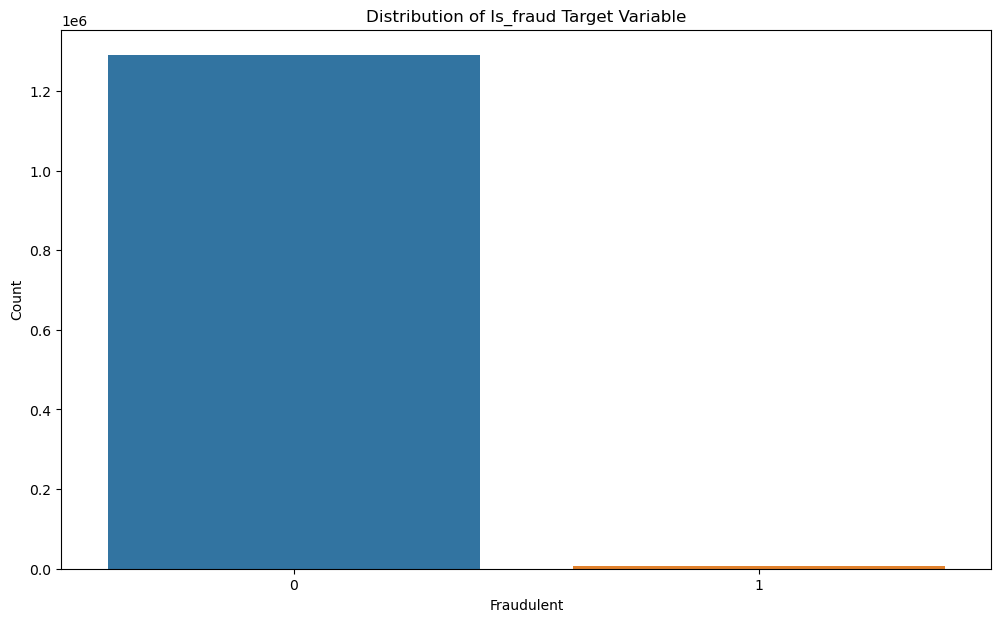

In [25]:
    # Visualize the distribution 
plt.figure(figsize=(12, 7))
sns.countplot(x= df['is_fraud'], data=df)
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.title('Distribution of Is_fraud Target Variable')
plt.show()

In [26]:
            ### Model Building and Visualiztion ###

In [27]:
    # make a simple check to print whether the data is imbalanced or not
is_imbalanced = fraud_distribution.min() / fraud_distribution.max() < 0.5
if is_imbalanced:
        print("The data is imbalanced.")
else:
        print("The data is not imbalanced.")

The data is imbalanced.


In [28]:
#   encode all object categorical variables
object_col = df.select_dtypes(['object']).columns
label_encoder = LabelEncoder()
for col in object_col:
    column_name = col + '_ENCODED'
    df[column_name] = label_encoder.fit_transform(df[col])

df.drop(columns=object_col, axis=1, inplace=True)

In [29]:
X = df.drop('is_fraud',axis=1) #--> Features
y = df['is_fraud']  # --> Target variable

In [30]:
df.head()

,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,...,merchant_ENCODED,category_ENCODED,first_ENCODED,last_ENCODED,gender_ENCODED,street_ENCODED,city_ENCODED,state_ENCODED,job_ENCODED,trans_num_ENCODED
0,737060,2703186189652095,4.97,28654,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,...,514,8,162,18,0,568,526,27,370,56438
1,737060,630423337322,107.23,99160,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,...,241,4,309,157,0,435,612,47,428,159395
2,737060,38859492057661,220.11,83252,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,...,390,0,115,381,1,602,468,13,307,818703
3,737060,3534093764340240,45.00,59632,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,...,360,2,163,463,1,930,84,26,328,544575
4,737060,375534208663984,41.96,24433,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,...,297,9,336,149,1,418,216,45,116,831111


In [31]:
 #   Check the number of rows in X and y
if X.shape[0] != y.shape[0]:
        raise ValueError("Number of rows in X_encoded and y do not match.")

In [32]:
    #   Divide the data into a 70% train and 30% test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:

#   HyperParameter tuning LogReg
logreg_hyperparam = LogisticRegression()
#   run GridsearchCV to determine the optimal parameters C, solver, and max_iter to go with 
param_grid = {
    'C': [0.1, 1, 10],
    'solver' : ['saga', 'lbfgs', 'liblinear'],
    'max_iter': [100,1000,5000]
}

clf = GridSearchCV(logreg_hyperparam, param_grid= param_grid, cv=4, verbose=1, n_jobs=-1)
clf.fit(X,y)
print("Best parameters:", clf.best_params_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
Best parameters: {'C': 0.1, 'max_iter': 100, 'solver': 'saga'}


In [34]:
#   Apply the info from the gridsearch, which identified the optimal parameters as C=0.1, max_iter=100, and solver = saga
#   plug it in and run the new instance 
logistic_regression_model = LogisticRegression(max_iter=100, solver='saga', C= 0.1, n_jobs= -1)
logistic_regression_model.fit(X_train, y_train)

LogisticRegression(C=0.1, n_jobs=-1, solver='saga')

In [35]:
# Run K Fold cross-validation to assess the performance of DTC on data
decision_tree_model = DecisionTreeClassifier()
cv_results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the Decision Tree model on the training data
    decision_tree_model.fit(X_train, y_train)
    
    # Evaluate the model on the test data and store the result
    accuracy = decision_tree_model.score(X_test, y_test) 
    cv_results.append(accuracy)

# Calculate average accuracy
average_accuracy = sum(cv_results) / 5  
print(f'Average Accuracy: {average_accuracy}')

Average Accuracy: 0.9962542657180867


In [36]:
# run gridsearch CV for optimal max depth on DT
param_grid = {'max_depth': [5, 10, 15, 20]}

decision_tree_classifier = DecisionTreeClassifier()

DT_grid_search = GridSearchCV(decision_tree_classifier, param_grid, verbose=1, cv=5)
DT_grid_search.fit(X_train, y_train)  

# get the best hyperparameters
best_max_depth = DT_grid_search.best_params_['max_depth']
print(f'Best max_depth: {best_max_depth}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best max_depth: 10


In [37]:
#   run the final decision tree with the optimal max depth
final_decision_tree_model = DecisionTreeClassifier(max_depth=best_max_depth)
final_decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [38]:
# Create and train the Random Forest model       NOTE TO SELF: RFC takes about 9 minutes to run at 100 estimators on here, comment it out for now
rfmodel = RandomForestClassifier(n_estimators=100, random_state=42)
rfmodel.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [39]:
# run the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [40]:
     # Print the breakdowns to see how each model performed
def evaluate_models(model, X_test, y_test):
        y_pred = model.predict(X_test)
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Accuracy:", accuracy_score(y_test, y_pred))

print("Logistic Regression Model:")
evaluate_models(logistic_regression_model, X_test, y_test)

print("\nDecision Tree Model:")
evaluate_models(final_decision_tree_model, X_test, y_test)

print("\nRandom Forest Model results:")
evaluate_models(rfmodel, X_test, y_test)

print("\nXGBoost Model:")
evaluate_models(xgb_model, X_test, y_test)

Logistic Regression Model:
Confusion Matrix:
[[257843      0]
 [  1492      0]]
Classification Report:


c:\Users\adamm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\adamm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\adamm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257843
           1       0.00      0.00      0.00      1492

    accuracy                           0.99    259335
   macro avg       0.50      0.50      0.50    259335
weighted avg       0.99      0.99      0.99    259335

Accuracy: 0.994246823606532

Decision Tree Model:
Confusion Matrix:
[[257582    261]
 [   453   1039]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257843
           1       0.80      0.70      0.74      1492

    accuracy                           1.00    259335
   macro avg       0.90      0.85      0.87    259335
weighted avg       1.00      1.00      1.00    259335

Accuracy: 0.9972468043264503

Random Forest Model results:
Confusion Matrix:
[[257749     94]
 [   489   1003]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1

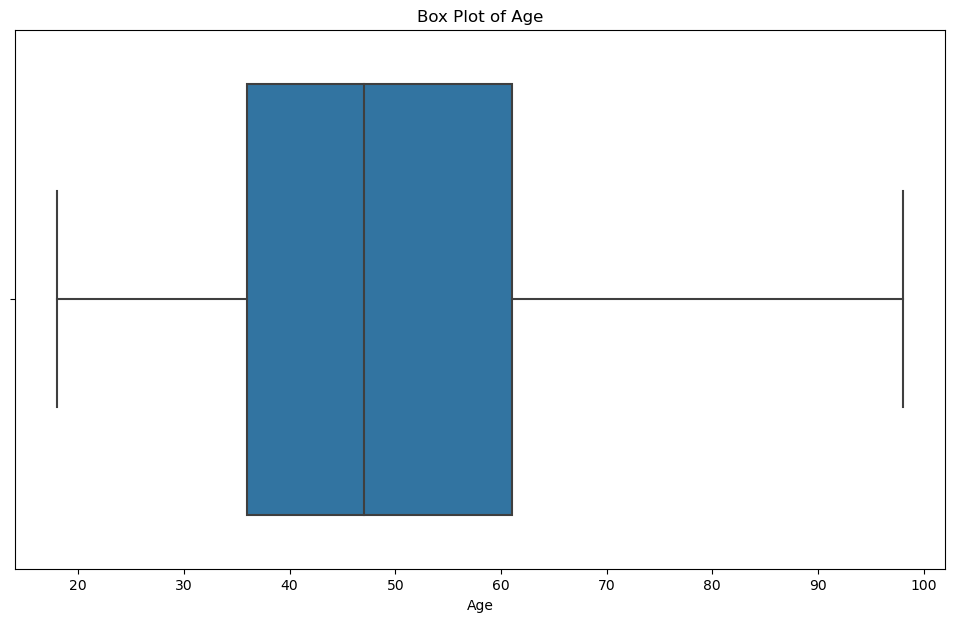

In [41]:
        # Box Plot creation 
#   outliers in age are quite unlikely, but this still helps get a look at the distribution: ages 18 to 98
plt.figure(figsize=(12, 7))
sns.boxplot(x='age', data=df)
plt.xlabel('Age')
plt.title('Box Plot of Age')
plt.show()

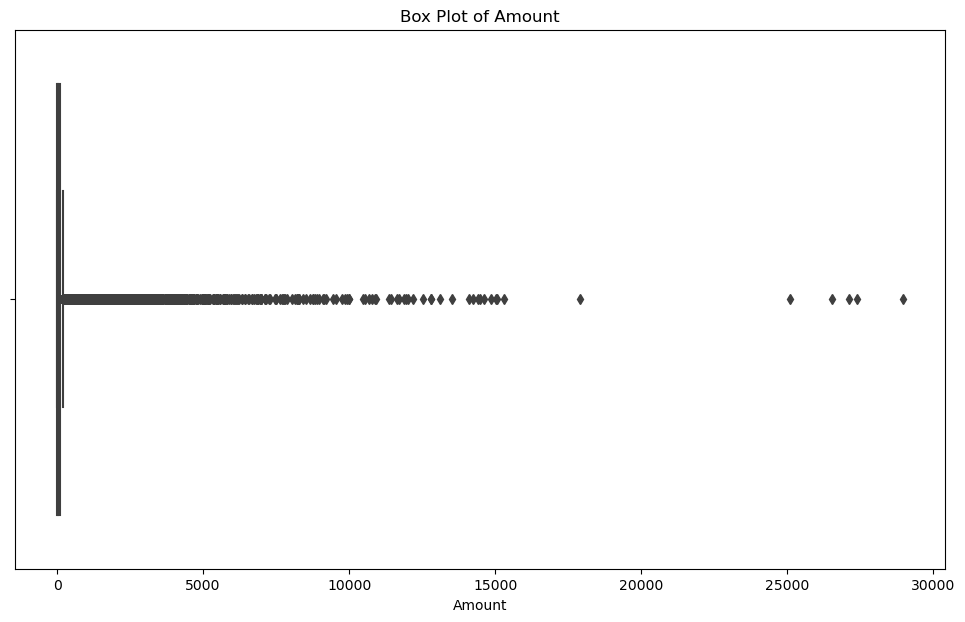

,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,...,merchant_ENCODED,category_ENCODED,first_ENCODED,last_ENCODED,gender_ENCODED,street_ENCODED,city_ENCODED,state_ENCODED,job_ENCODED,trans_num_ENCODED
187885,737156,6538441737335434,17897.24,16114,41.3851,-80.1752,606,1333812743,41.361042,-79.665772,...,621,13,133,169,0,449,148,38,152,145154
352894,737224,5540636818935089,25086.94,1843,42.6911,-71.1605,76383,1339704938,42.397174,-71.474163,...,216,13,201,138,1,334,435,19,215,58645
606211,737316,30408301059761,26544.12,29436,33.3364,-80.1859,4471,1347661141,33.020256,-80.125607,...,71,13,41,343,1,291,185,40,314,1122886
787549,737394,4979422371139333,28948.90,68881,41.4193,-99.3844,73,1354378763,42.317313,-99.139498,...,544,13,198,479,0,184,866,29,356,246181
793677,737395,675909898057,27390.12,10504,41.1360,-73.7009,7987,1354463626,41.665873,-74.663015,...,432,13,74,187,1,110,29,34,460,226052
1234797,737575,60423098130,27119.77,73719,36.9412,-98.2458,83,1369935090,37.286865,-97.249611,...,432,13,157,166,1,871,20,36,45,736253


In [42]:
#   Amt box plot, a look at outliers, my opinions shared below the plot
plt.figure(figsize=(12, 7))
sns.boxplot(x='amt', data=df)
plt.xlabel('Amount')
plt.title('Box Plot of Amount')
plt.show()

df[df['amt']>17000]

In [43]:
'''  outliers in Amount: we can see a clear showing of 6 outliers each over the $17,000 threshold. 
When it comes to fraud, it is my opinion that they cannot be excluded, and are an essential part of the dataset.

It is worth noting that ALL 6 of these outliers share the same category: travel (category 13 when ENCODED).
The same merchant is on there twice as well: "fraud_Monahan, Hermann and Johns" 
'''

'  outliers in Amount: we can see a clear showing of 6 outliers each over the $17,000 threshold. \nWhen it comes to fraud, it is my opinion that they cannot be excluded, and are an essential part of the dataset.\n\nIt is worth noting that ALL 6 of these outliers share the same category: travel (category 13 when ENCODED).\nThe same merchant is on there twice as well: "fraud_Monahan, Hermann and Johns" \nThese are shown in the df[df[\'amt\']>17000] statement below\n'